# SARIMA MODELS 2

In this notebook, we are going to fit a SARIMA MODEL by using the dataset with COVID data.

## 📑 Index  
* [1. EXPLORATORY PLOTS](#expl)
* [2. TRANSFORMATIONS TO GET A STATIONARY TIME SERIES](#trans)
* [3. IDENTIFYING THE *ARMA* STRUCTURE $(p, q, P, Q)$](#id)
* [4. MODEL SELECTION](#sel)
* [5. MODEL FIT AND PREDICTION. FINAL ERRORS TEST](#fit)

Import the packages.

In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from pmdarima import auto_arima
import scipy.stats as sc

import matplotlib.pyplot as plt

import statsmodels
import statsmodels.tsa.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn import metrics

from pathlib import Path
import joblib

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

plt.style.use("fivethirtyeight")
plt.rcParams["lines.linewidth"] = 1.5
dark_style = {
    "figure.facecolor": "#212946",
    "axes.facecolor": "#212946",
    "savefig.facecolor": "#212946",
    "axes.grid": True,
    "axes.grid.which": "both",
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "grid.color": "#2A3459",
    "grid.linewidth": "1",
    "text.color": "0.6",
    "axes.labelcolor": "0.6",
    "xtick.color": "0.6",
    "ytick.color": "0.6",
    "font.size": 12,
}
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams["figure.figsize"] = (18, 7)

We load the data and consider that our data set goes from 2003 to 2023 (with COVID).

In [2]:
df = pd.read_csv(
    "C:/Users/Juanfran cd/Desktop/MATEMATICAS UA/TFG/air traffic.csv",
    encoding="ISO-8859-1",
)

# Clean and convert 'Pax' to number
df["Pax"] = df["Pax"].str.replace(",", "", regex=True).astype(float)

# Create date column in YYYY-MM format
df["Date"] = pd.to_datetime(
    df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2), format="%Y-%m"
)

# Keep only the 'Date' and 'Pax' columns
df1 = df[["Date", "Pax"]]

We split our data set into 2: a training set (from 2003 to 2017) and a test set (from 2018 to 2019).

In [3]:
train = df1.loc[df1["Date"] <= "2021-12-01"]
test = df1.loc[df1["Date"] >= "2022-01-01"]

<a id='expl'></a>
## 1. EXPLORATORY PLOTS

Plot of the original time series

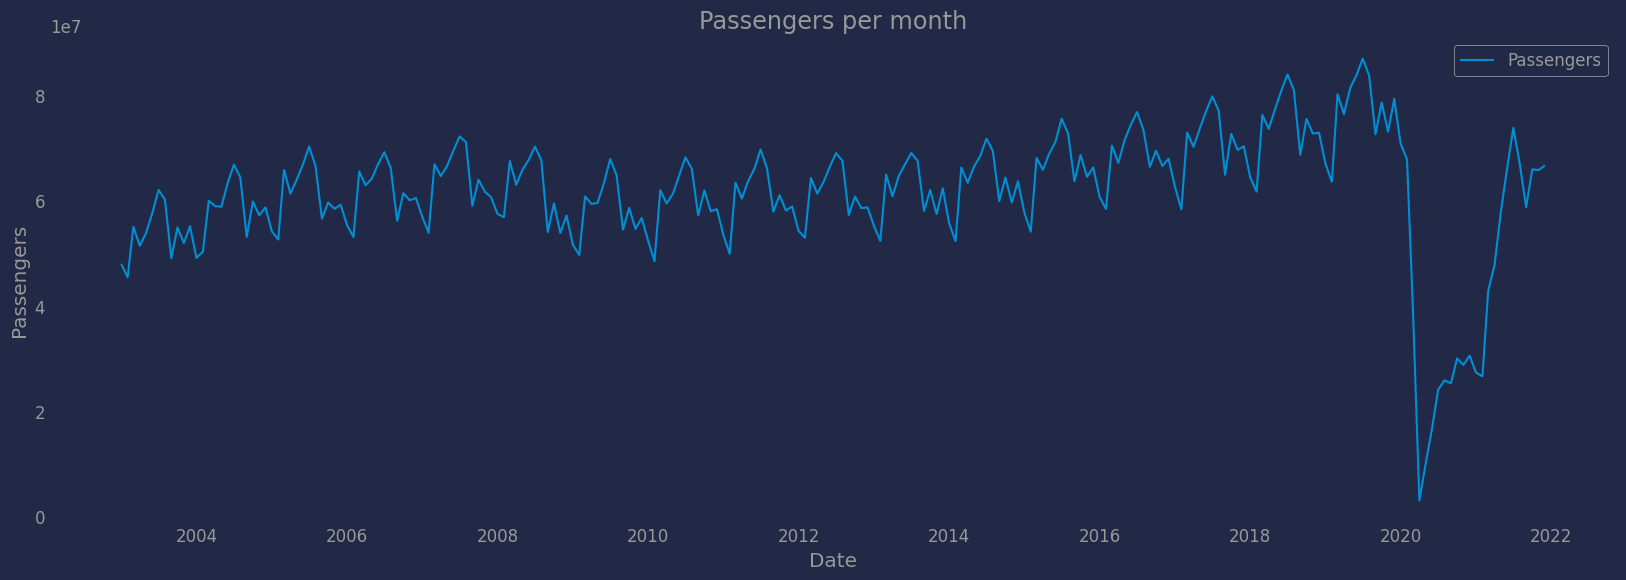

In [4]:
plt.figure(figsize=(18, 6))
sns.lineplot(x="Date", y="Pax", data=train, label="Passengers")
plt.title("Passengers per month")
plt.ylabel("Passengers")
plt.legend()
plt.grid()
plt.show()

Seasonal plot

In [5]:
def SEASONAL_PLOT(series, freq, title="Seasonal Plot"):
    series.index = pd.to_datetime(series.index)

    df = series.copy()
    df = df.rename(columns={df.columns[0]: "value"})

    df["year"] = df.index.year
    df["season"] = df.index.month if freq == 12 else df.index.dayofyear

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        x="season", y="value", hue="year", data=df, palette="tab10", marker="o"
    )

    plt.title(title)
    plt.xlabel("Mes" if freq == 12 else "Período Estacional")
    plt.ylabel("Valor")
    plt.legend(title="Año", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

C:\Users\Juanfran cd\AppData\Local\Temp\ipykernel_23140\3880566452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Date"] = pd.to_datetime(train["Date"])


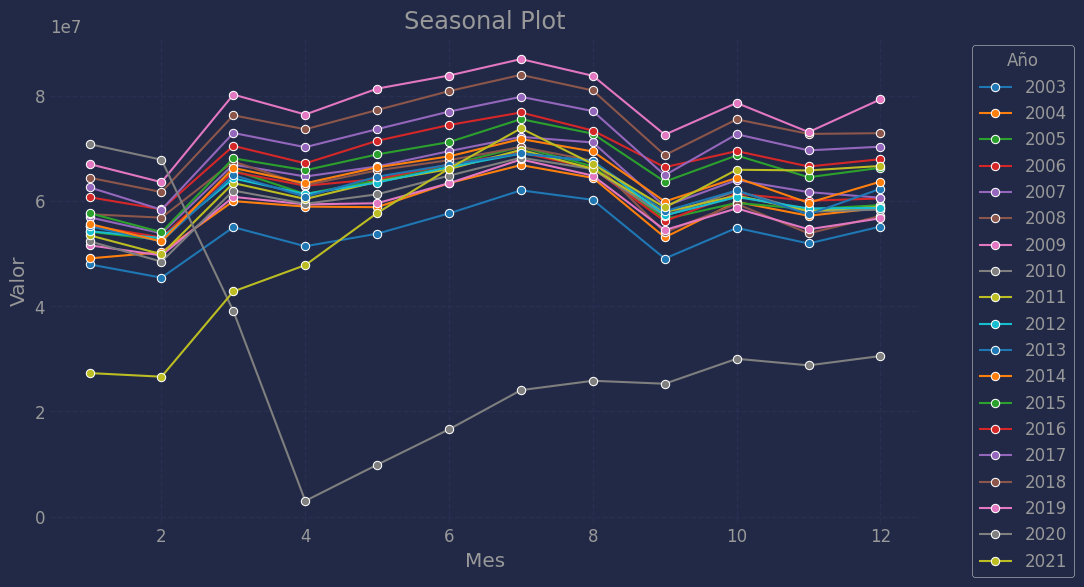

In [6]:
# Make sure 'Date' is datetime type and set it as index
train["Date"] = pd.to_datetime(train["Date"])
train = train.set_index("Date")

SEASONAL_PLOT(train, freq=12)

Plot var function: this plot shows the relationship between the logarithm of the mean and the logarithm of the standard deviation.

In [7]:
def PLOT_VAR(x, n_tilde):
    x = np.array(x)

    m = len(x) // n_tilde
    x = x[: m * n_tilde]

    A_temp = x.reshape(m, n_tilde)

    xbar_vec = A_temp.mean(axis=1)
    s_vec = A_temp.std(axis=1, ddof=1)

    plt.figure(figsize=(8, 6))
    plt.scatter(np.log(xbar_vec), np.log(s_vec), marker="o", color="blue")
    plt.xlabel("log(mean)")
    plt.ylabel("log(standard deviation)")
    plt.title(f"Number of observations per group: {n_tilde}")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

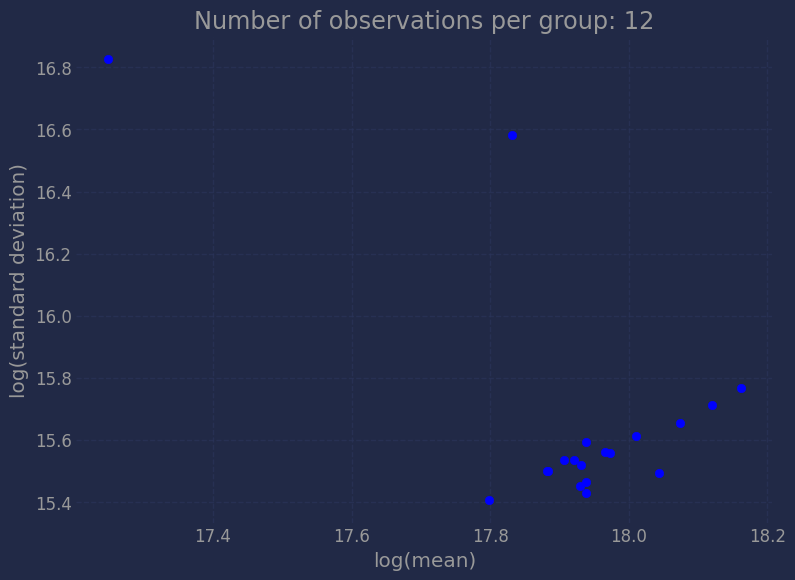

In [8]:
PLOT_VAR(train, 12)

After observing those plots, the suggest:
* That the mean is not constant over time since:
   - The presence of a trend component, because the number of passengers grows throughout the years, except during COVID
   - The presence of a seasonal component with period s=12.
* How the variance is also not constant, because it increases as the series progresses.

Thus, we can say that the series is not stationary.

<a id='trans'></a>
## 2. TRANSFORMATIONS TO GET A STATIONARY TIME SERIES

As we have concluded that our dataset is not a stationary, let's apply two tranformationst o make our series stationary:
* A variance stabilizing transformations: $\hat{X}_t = g(X_t)$
* A mean stabilizing transformations: $W_t = ∇_{s}^D ∇^d \hat{X}_t$

Let’s start with the variance stabilizing transformation.

### 2.1 Variance stabilizing transformations

As we have seen in the previous point,the relationship between the logarithm of the mean and the logarithm of the standard deviationfor our data (that has 12 observations per group) is approximately linear, so we can apply a Box-Cox transformation.

In [9]:
def INV_BOXCOX(y, ld):
    if ld == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(ld * y + 1) / ld)

In [10]:
X = sc.boxcox(train["Pax"])
l = X[1]
print("lambda = ", l)

lambda =  2.3290243561502306


In [11]:
X = pd.DataFrame(X[0], index=train.index, columns=["Pax"])
X

,Pax
Date,
2003-01-01,3.321410e+17
2003-02-01,2.927967e+17
2003-03-01,4.574497e+17
2003-04-01,3.903262e+17
2003-05-01,4.338242e+17
...,...
2021-08-01,7.240434e+17
2021-09-01,5.332945e+17
2021-10-01,6.971165e+17


Transformed series obtained using Box-Cox transformation with lambda=2.33

<Figure size 1200x600 with 0 Axes>

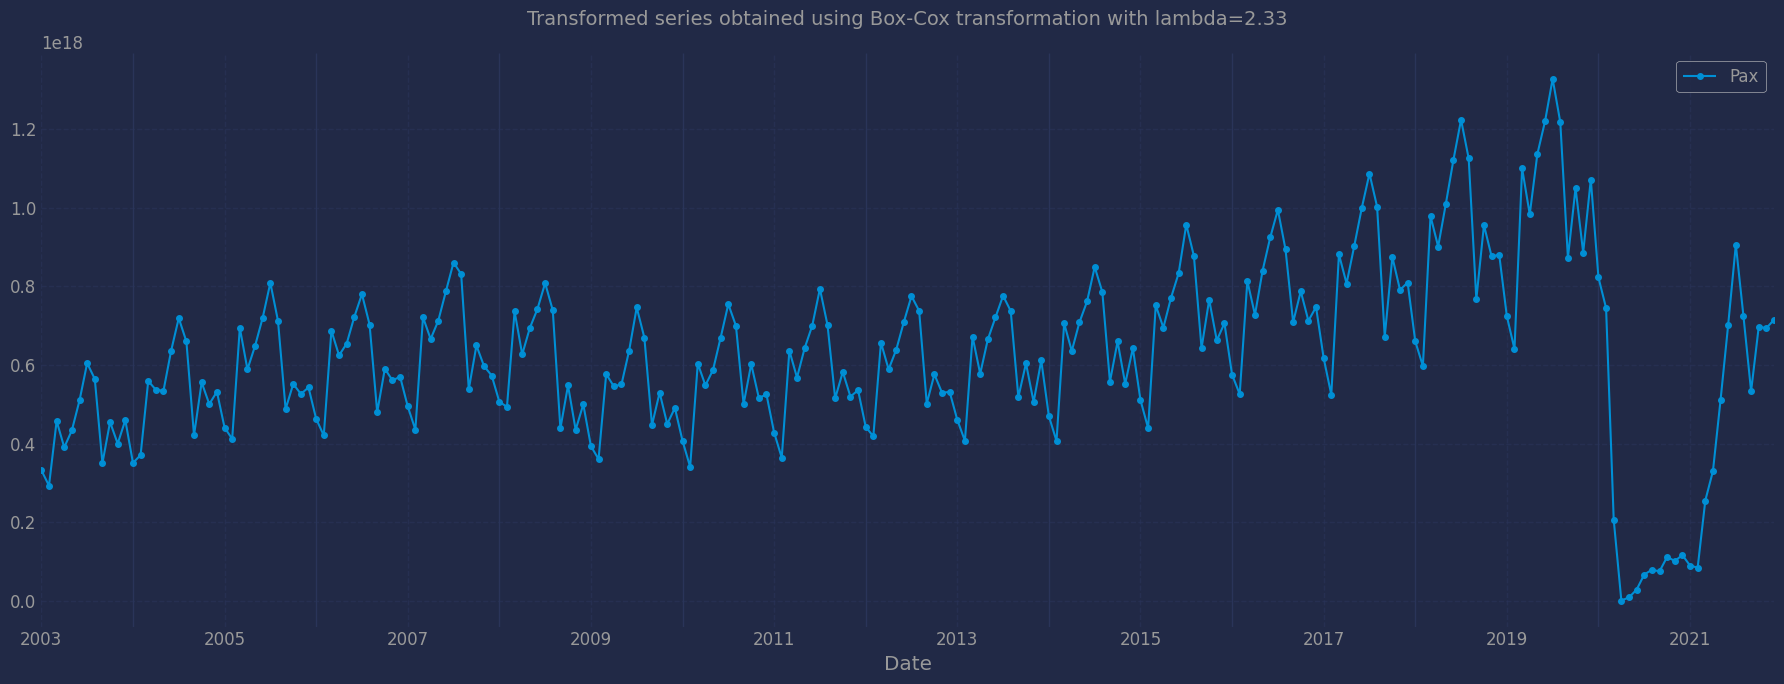

In [12]:
plt.figure(figsize=(12, 6))
X.plot(marker=".", markersize=8, linestyle="-")
plt.title(
    "Transformed series obtained using Box-Cox transformation with lambda=2.33",
    fontsize=14,
    pad=20,
)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### 2.2 Mean stabilizing transformations

Once we have stabilized the variance, we have to stabilize the mean by following two steps:
 1. Removing the trend component.
 2. Removing the seasonal component.

#### 2.2.1 Trend component (determining $d$)

In the transformed series plot, we can notice the presence of a linear trend component. Then, we have to apply the regular differencing operator $∇^d = (1 − B)^d$, with $d≥1$ in order to remove this trend.

We start checking the results of the Aumented Dickey-Fuller test, where the null hypothesis is:

$$ H_{0}: X_{t} \quad \text{is not stationary}$$

In [13]:
def AUGMENTED_DICKEY_FULLER_TEST_FUNC(series, column_name):
    print(f"Dickey-Fuller test results for column: {column_name}")
    dftest = adfuller(series, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "No Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusions:")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusions")
        print("Do not reject the null hypothesis")
        print("The data is not stationary")

In [14]:
AUGMENTED_DICKEY_FULLER_TEST_FUNC(X["Pax"], "Pax")

Dickey-Fuller test results for column: Pax
Test Statistic                  -0.544624
p-value                          0.883010
No Lags Used                    14.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64
Conclusions
Do not reject the null hypothesis
The data is not stationary


According to the Dickey-Fuller test, the time series is not stationary because the p-value is greater than $0.05$. Then, let's apply the regular differencing operator once.

$$W_{t} = ∇X_{t} = X_{t} - X_{t-1}$$

In [15]:
W1 = (X - X.shift(1)).dropna()

Dickey-Fuller test results for column: Pax
Test Statistic                  -4.916379
p-value                          0.000032
No Lags Used                    15.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64
Conclusions:
Reject the null hypothesis
The data is stationary


<Axes: xlabel='Date'>

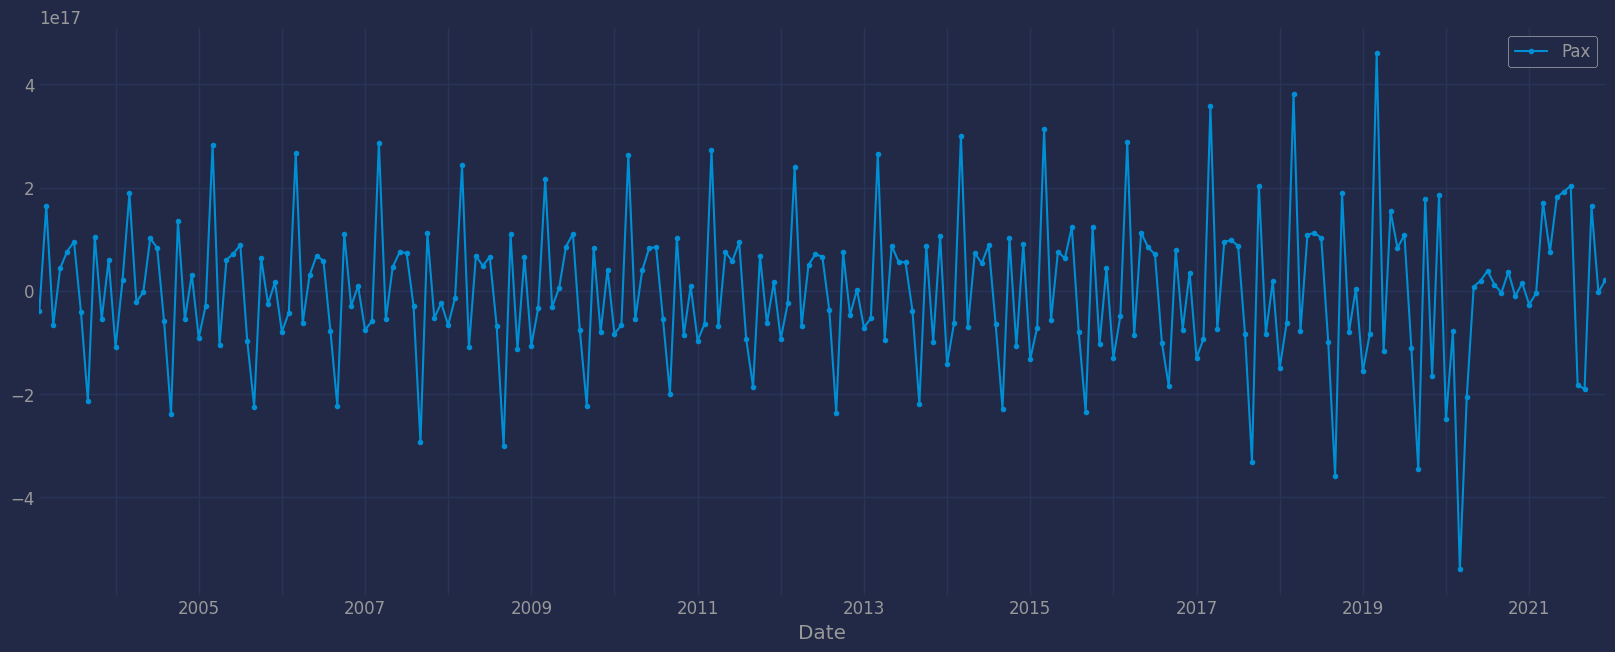

In [16]:
AUGMENTED_DICKEY_FULLER_TEST_FUNC(W1["Pax"], "Pax")
W1.plot(marker=".")

According to the Dickey-Fuller test, the time series stationary because the p-value is not greater than $0.05$ and if we look at that plot, we can see that we have removed the trend component. Hence, we choose $d=1$.

#### 2.2.2 Seasonal component (determining $D$)

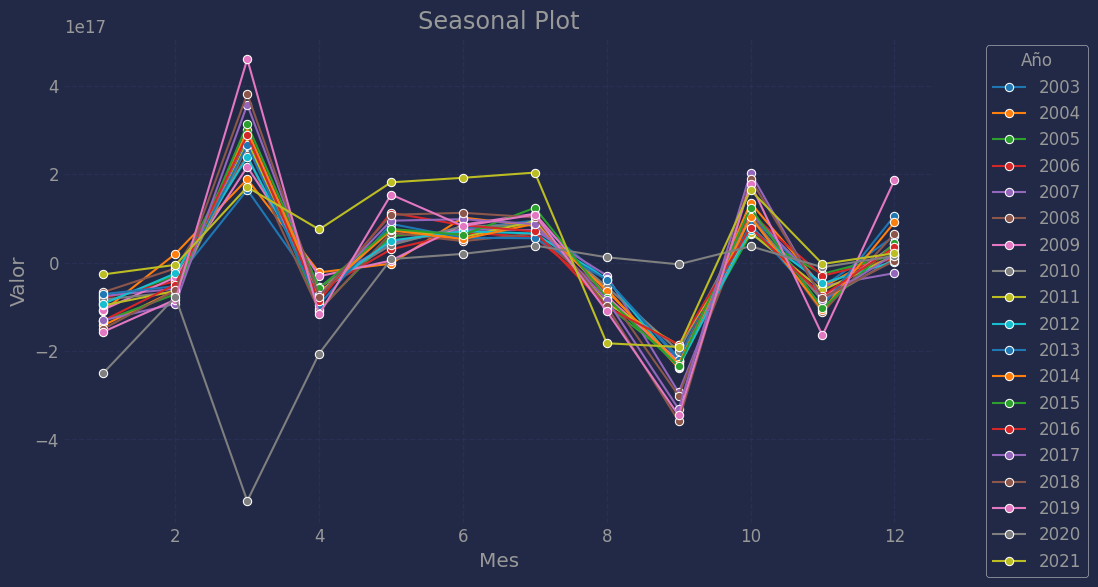

In [17]:
SEASONAL_PLOT(W1, freq=12)

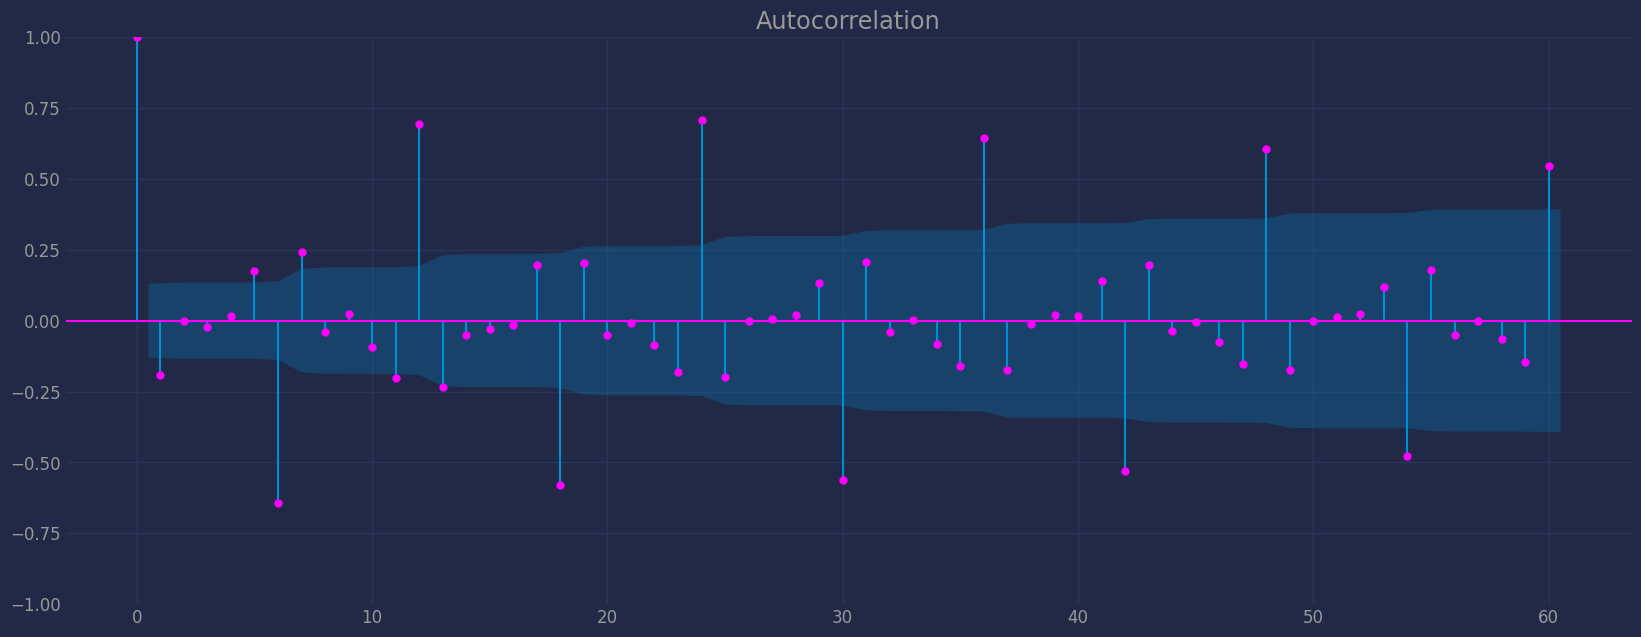

In [18]:
plot_acf(W1["Pax"], lags=60, color="fuchsia")
plt.show()

As we can see in the seasonal plot, the same pattern is repeated every s=12, that is, every year. In addition, the ACF of the series ${W1_𝑡}$ follows trend everys=12 and slowly decreases overtime.

Then, we have to apply the seasonal difference operator $∇_{12}=(1−𝐵^{12})$ to remove the seasonal component.

$$W2_{t} = ∇_{12}W1_{𝑡}$$

In [19]:
W2 = (W1 - W1.shift(12)).dropna()

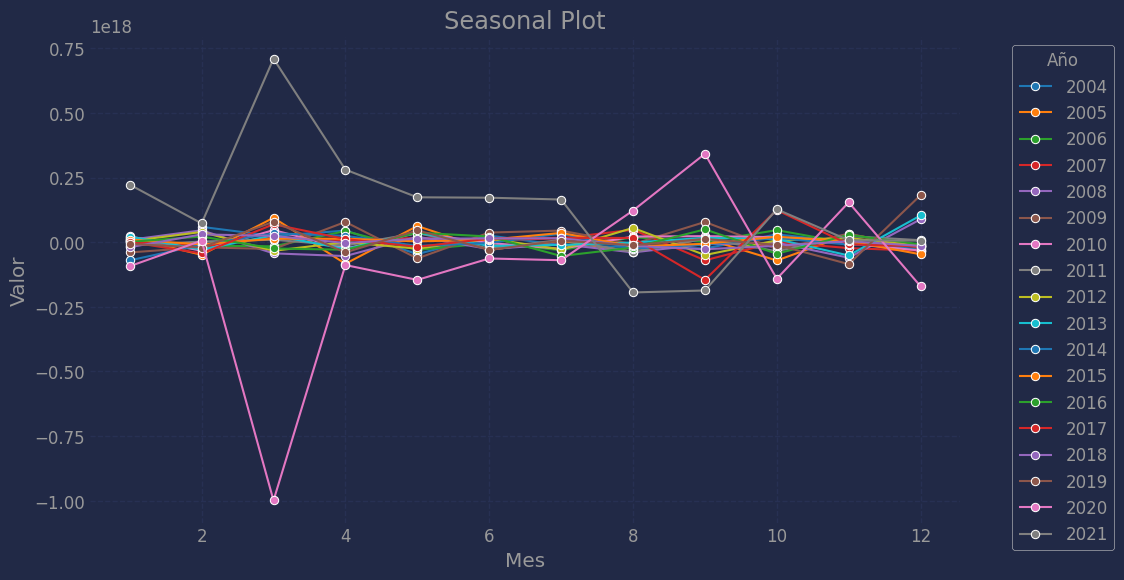

In [20]:
SEASONAL_PLOT(W2, freq=12)

Dickey-Fuller test results for column: Pax
Test Statistic                -9.228127e+00
p-value                        1.707093e-15
No Lags Used                   1.100000e+01
Number of Observations Used    2.030000e+02
Critical Value (1%)           -3.462980e+00
Critical Value (5%)           -2.875885e+00
Critical Value (10%)          -2.574416e+00
dtype: float64
Conclusions:
Reject the null hypothesis
The data is stationary


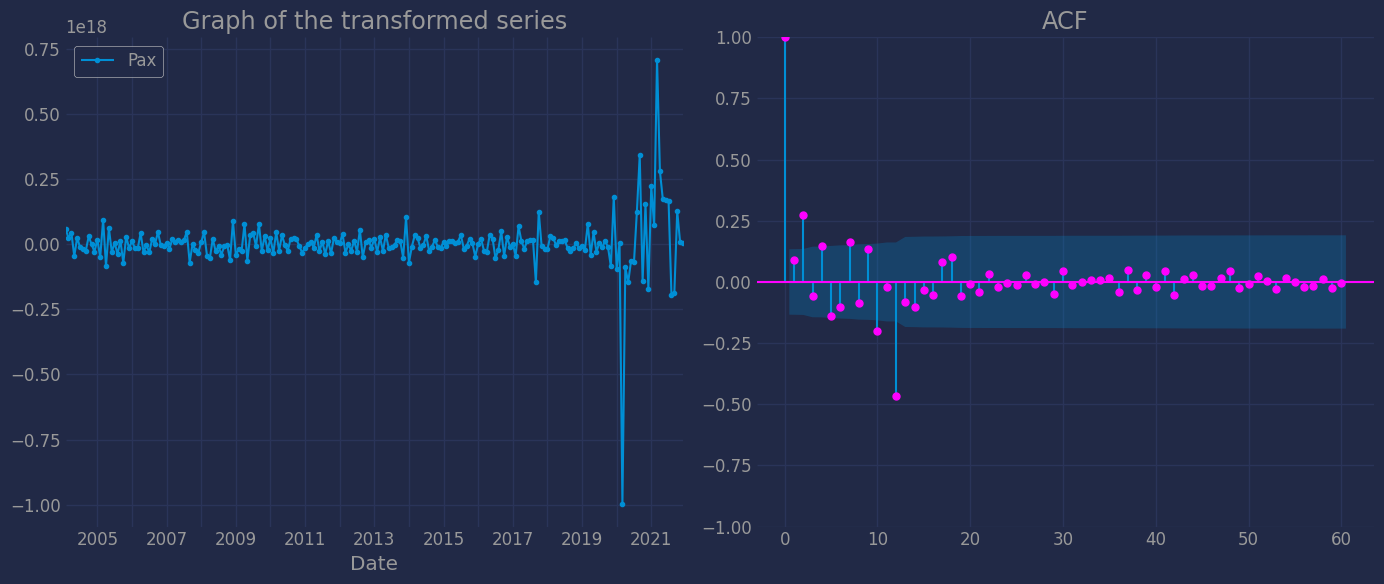

In [21]:
AUGMENTED_DICKEY_FULLER_TEST_FUNC(W2["Pax"], "Pax")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

W2.plot(marker=".", ax=axes[0])
axes[0].set_title("Graph of the transformed series")

plot_acf(W2["Pax"], lags=60, color="fuchsia", ax=axes[1])
axes[1].set_title("ACF")

plt.tight_layout()
plt.show()

We notice that according to the according to the Dickey-Fuller test, the time series is still stationary and the graph and the ACF of the transformed series do not show obvious deviations from stationarity.

Hence, we set the value $D=1$.

<a id='id'></a>
## 3. IDENTIFYING THE *ARMA* STRUCTURE $(p, q, P, Q)$

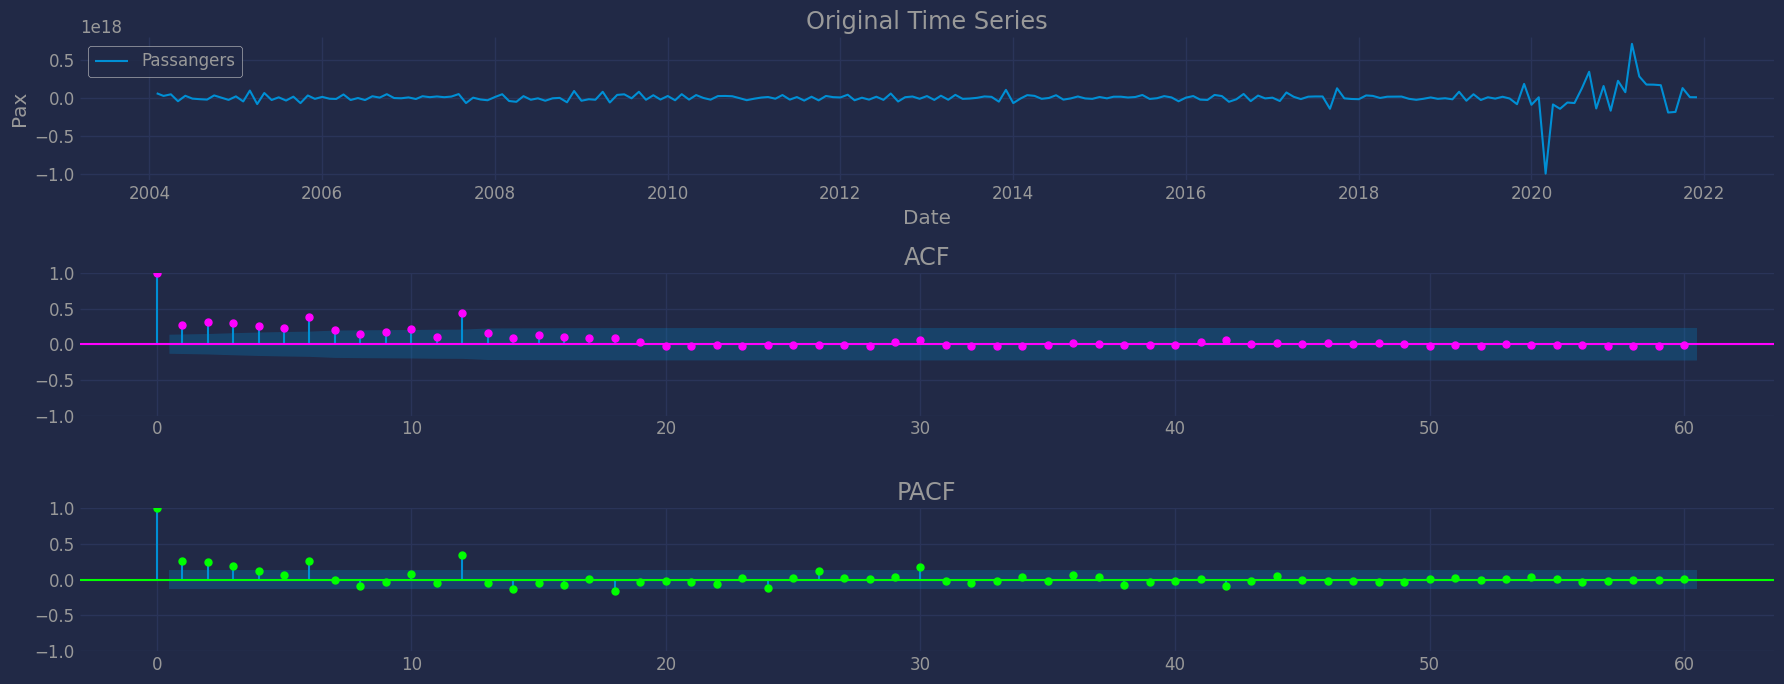

In [22]:
fig, axs = plt.subplots(nrows=3, ncols=1)

sns.lineplot(data=W2, x="Date", y="Pax", label="Passangers", ax=axs[0]).set_title(
    "Original Time Series"
)

plot_acf(np.abs(W2["Pax"]), lags=60, color="fuchsia", ax=axs[1])
axs[1].set_title("ACF")

plot_pacf(np.abs(W2["Pax"]), lags=60, color="lime", ax=axs[2])
axs[2].set_title("PACF")

plt.tight_layout()
plt.show()

1. **p** (AR order - Autoregressive): it can be estimated from the PACF. Find the first cut (significant peak) on the PACF graph. The number of lags up to which the PACF cuts off (becomes non-significant) is the value of p. $$p=1$$

2. **q** (MA order - Moving average): it can be estimated from the ACF. Find the first cut (significant peak) on the ACF graph. The number of lags up to which the ACF cuts off (becomes non-significant) is the value of q. $$q=1 \quad \text{ or } \quad q=2$$

3. **P** (seasonal AR): it can be estimated from the seasonal PACF. In the case of a SARIMA model, the PACF is analyzed at multiple lags of the seasonality (for example, if the seasonality is 12 periods, the PACF is observed at lags 12, 24, 36, etc.). The first significant cut in these delays is the value of P. $$P=1$$

4. **Q** (seasonal MA): similar to the P value, it can be estimated from the seasonal ACF. Look at the seasonal delays (multiplied by seasonality, such as 12, 24, 36, etc.) and look for the first significant break in these delays. That is the value of Q. $$Q=1$$

<a id='sel'></a>
## 4. MODEL SELECTION

$$ARIMA(P,D,Q)_s × (p,d,q)$$

We use the AIC, AICc and BIC criteria to select the model that best suit our data.

In [23]:
D = 1
d = 1

p_values = [0, 1]
q_values = [0, 1, 2]
P_values = [0, 1]
Q_values = [0, 1]

results = []

for p in p_values:
    for q in q_values:
        for Q in Q_values:
            for P in P_values:
                try:
                    model = ARIMA(X, order=(p, d, q), seasonal_order=(P, D, Q, 12))
                    model_fit = model.fit()

                    aic = model_fit.aic
                    bic = model_fit.bic

                    n = len(X)
                    aicc = aic + (2 * (p + q + 1) * (p + q + 2)) / (n - p - q - 2)

                    results.append(
                        {
                            "p": p,
                            "q": q,
                            "P": P,
                            "Q": Q,
                            "AIC": aic,
                            "AICc": aicc,
                            "BIC": bic,
                        }
                    )
                except Exception as e:
                    print(f"Error fitting ARIMA({p},{d},{q}) model: {e}")

if results:
    results_df = pd.DataFrame(results)
    results_df_sorted = results_df.sort_values(by=["AIC", "AICc", "BIC"])
    top_4_models = results_df_sorted.head(7)
    print(top_4_models)
else:
    print("No valid models were found.")

    p  q  P  Q           AIC          AICc           BIC
3   0  0  1  1  17371.887081  17371.904780  17381.998995
2   0  0  0  1  17372.421173  17372.438872  17379.162449
22  1  2  0  1  17383.839987  17384.019359  17400.693177
10  0  2  0  1  17385.570289  17385.677432  17399.052841
23  1  2  1  1  17385.646722  17385.826094  17405.870550
11  0  2  1  1  17387.527157  17387.634300  17404.380347
14  1  0  0  1  17389.068232  17389.121565  17399.180146


According to the AIC, AICc and BIC criteria, the top 7 models are: 

1. $ARIMA(1,1,1)_{12} × (0,1,0)$
2. $ARIMA(0,1,1)_{12} × (0,1,0)$
3. $ARIMA(0,1,1)_{12} × (1,1,2)$
4. $ARIMA(0,1,0)_{12} × (0,1,2)$
5. $ARIMA(1,1,1)_{12} × (1,1,2)$
6. $ARIMA(1,1,1)_{12} × (0,1,2)$
7. $ARIMA(0,1,1)_{12} × (1,1,0)$

In [24]:
# This helps us to choose the best model

# Fit the model with AIC
model_aic = auto_arima(
    train["Pax"].values,
    start_p=0,
    start_q=0,
    test="adf",
    max_p=1,
    max_q=1,
    d=1,
    m=12,
    seasonal=True,
    start_P=0,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=False,
    information_criterion="aic",
)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=7322.669, Time=0.03 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,1)[12]             : AIC=7224.963, Time=0.19 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,2)[12]             : AIC=7246.595, Time=1.05 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,0)[12]             : AIC=7265.745, Time=0.37 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,1)[12]             : AIC=7224.653, Time=0.35 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.94 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,0)[12]             : AIC=7239.389, Time=0.46 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,1)[12]             : AIC=7224.732, Time=1.26 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,2)[12]             : AIC=7229.364, Time=2.60 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=7300.200, Time=0.07 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=7218.202, Time=0.29 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,2)[12]             : AIC=7220.192, Time=1.69 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,0)[12]             : AIC=7241.845, Time=0.66 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,1)[12]             : AIC=7220.195, Time=0.68 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.59 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=7228.611, Time=0.69 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,1)[12]             : AIC=7221.149, Time=1.50 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,2)[12]             : AIC=7222.079, Time=3.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=7298.237, Time=0.06 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[12]             : AIC=7218.184, Time=0.30 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,2)[12]             : AIC=7220.120, Time=1.98 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=7241.468, Time=0.59 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[12]             : AIC=7220.134, Time=0.81 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=2.55 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[12]             : AIC=7228.499, Time=0.68 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[12]             : AIC=7221.082, Time=1.53 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,2)[12]             : AIC=7222.066, Time=2.94 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=7300.127, Time=0.13 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=7219.162, Time=0.43 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,2)[12]             : AIC=7221.137, Time=2.33 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=7242.730, Time=0.72 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,1)[12]             : AIC=7221.143, Time=0.82 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=3.83 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=7229.630, Time=1.22 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,1)[12]             : AIC=7222.097, Time=1.83 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit time: 42.387 seconds


In [25]:
# Fit the model with AICc
model_aicc = auto_arima(
    train["Pax"].values,
    start_p=0,
    start_q=0,
    test="adf",
    max_p=1,
    max_q=2,
    d=1,
    m=12,
    seasonal=True,
    start_P=0,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=False,
    information_criterion="aicc",
)

 ARIMA(0,1,0)(0,1,0)[12]             : AICC=7322.686, Time=0.03 sec

c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 ARIMA(0,1,0)(0,1,1)[12]             : AICC=7225.016, Time=0.20 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,2)[12]             : AICC=7246.702, Time=1.22 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,0)[12]             : AICC=7265.798, Time=0.46 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,1)[12]             : AICC=7224.761, Time=0.32 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,2)[12]             : AICC=inf, Time=2.13 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,0)[12]             : AICC=7239.496, Time=0.49 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,1)[12]             : AICC=7224.911, Time=1.29 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,2)[12]             : AICC=7229.635, Time=2.76 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AICC=7300.254, Time=0.06 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AICC=7218.309, Time=0.30 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,2)[12]             : AICC=7220.372, Time=2.09 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,0)[12]             : AICC=7241.952, Time=0.46 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,1)[12]             : AICC=7220.374, Time=0.62 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,2)[12]             : AICC=inf, Time=2.76 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,0)[12]             : AICC=7228.790, Time=0.62 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,1)[12]             : AICC=7221.419, Time=1.64 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,2)[12]             : AICC=7222.459, Time=3.32 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AICC=7298.850, Time=0.10 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,1)[12]             : AICC=7220.837, Time=0.32 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,2)[12]             : AICC=7222.903, Time=2.20 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,0)[12]             : AICC=7243.673, Time=0.68 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,1)[12]             : AICC=7222.908, Time=0.71 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,2)[12]             : AICC=inf, Time=3.78 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,1,0)[12]             : AICC=7231.127, Time=0.76 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,1,1)[12]             : AICC=7224.003, Time=1.72 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AICC=7298.290, Time=0.06 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[12]             : AICC=7218.291, Time=0.32 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,2)[12]             : AICC=7220.300, Time=1.67 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[12]             : AICC=7241.575, Time=0.54 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[12]             : AICC=7220.314, Time=0.73 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,2)[12]             : AICC=inf, Time=2.67 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[12]             : AICC=7228.678, Time=0.59 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[12]             : AICC=7221.352, Time=1.62 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,2)[12]             : AICC=7222.446, Time=2.96 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AICC=7300.234, Time=0.13 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,1)[12]             : AICC=7219.341, Time=0.50 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,2)[12]             : AICC=7221.407, Time=2.60 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[12]             : AICC=7242.910, Time=0.78 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,1)[12]             : AICC=7221.413, Time=0.99 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,2)[12]             : AICC=inf, Time=3.79 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,0)[12]             : AICC=7229.901, Time=1.14 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,1)[12]             : AICC=7222.477, Time=2.03 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,0)[12]             : AICC=7298.317, Time=0.35 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,1)[12]             : AICC=7222.235, Time=1.43 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,2)[12]             : AICC=7224.303, Time=3.52 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,0)[12]             : AICC=7244.863, Time=1.37 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,1)[12]             : AICC=7224.313, Time=1.77 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,1,0)[12]             : AICC=7232.459, Time=2.68 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit time: 65.383 seconds


In [26]:
# Fit the model with BIC
model_bic = auto_arima(
    train["Pax"].values,
    start_p=0,
    start_q=0,
    test="adf",
    max_p=1,
    max_q=2,
    d=1,
    m=12,
    seasonal=True,
    start_P=0,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=False,
    information_criterion="bic",
)

c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,0)[12]             : BIC=7326.039, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : BIC=7231.704, Time=0.20 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,2)[12]             : BIC=7256.707, Time=1.31 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,0)[12]             : BIC=7272.486, Time=0.43 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,1)[12]             : BIC=7234.765, Time=0.37 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,2)[12]             : BIC=inf, Time=2.01 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,0)[12]             : BIC=7249.501, Time=0.53 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,1)[12]             : BIC=7238.215, Time=1.20 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,2)[12]             : BIC=7246.217, Time=2.53 sec
 ARIMA(0,1,1)(0,1,0)[12]             : BIC=7306.941, Time=0.06 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : BIC=7228.314, Time=0.38 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,2)[12]             : BIC=7233.675, Time=1.71 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,0)[12]             : BIC=7251.957, Time=0.45 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,1)[12]             : BIC=7233.677, Time=0.70 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,2)[12]             : BIC=inf, Time=2.80 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,0)[12]             : BIC=7242.093, Time=0.63 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,1)[12]             : BIC=7238.002, Time=1.72 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,2)[12]             : BIC=7242.303, Time=3.39 sec
 ARIMA(0,1,2)(0,1,0)[12]             : BIC=7308.855, Time=0.08 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,1)[12]             : BIC=7234.141, Time=0.36 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,2)[12]             : BIC=7239.485, Time=2.27 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,0)[12]             : BIC=7256.976, Time=0.78 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,1)[12]             : BIC=7239.491, Time=0.81 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,2)[12]             : BIC=inf, Time=3.72 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,1,0)[12]             : BIC=7247.710, Time=0.79 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,1,1)[12]             : BIC=7243.847, Time=1.70 sec
 ARIMA(1,1,0)(0,1,0)[12]             : BIC=7304.978, Time=0.06 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[12]             : BIC=7228.295, Time=0.41 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,2)[12]             : BIC=7233.603, Time=1.38 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[12]             : BIC=7251.580, Time=0.63 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[12]             : BIC=7233.617, Time=0.67 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,2)[12]             : BIC=inf, Time=2.59 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[12]             : BIC=7241.981, Time=0.64 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[12]             : BIC=7237.935, Time=1.65 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,2)[12]             : BIC=7242.289, Time=3.12 sec
 ARIMA(1,1,1)(0,1,0)[12]             : BIC=7310.239, Time=0.17 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,1)[12]             : BIC=7232.644, Time=0.63 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,2)[12]             : BIC=7237.990, Time=2.40 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[12]             : BIC=7256.213, Time=0.67 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,1)[12]             : BIC=7237.996, Time=0.77 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,2)[12]             : BIC=inf, Time=4.25 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,0)[12]             : BIC=7246.484, Time=1.28 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,1)[12]             : BIC=7242.320, Time=1.75 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,0)[12]             : BIC=7311.621, Time=0.52 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,1)[12]             : BIC=7238.818, Time=1.02 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,2)[12]             : BIC=7244.147, Time=3.83 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,0)[12]             : BIC=7261.446, Time=1.63 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,1)[12]             : BIC=7244.157, Time=1.67 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,1,0)[12]             : BIC=7252.303, Time=2.77 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit time: 65.527 seconds


In [27]:
print("Modelo con AIC:")
print(model_aic.summary())

Modelo con AIC:
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  228
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -3606.092
Date:                              Sat, 03 May 2025   AIC                           7218.184
Time:                                      14:11:06   BIC                           7228.295
Sample:                                           0   HQIC                          7222.269
                                              - 228                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2767      0.028      9.995      0.000       0.222       0.331
ma.

In [28]:
print("Modelo con AICc:")
print(model_aicc.summary())

Modelo con AICc:
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  228
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -3606.092
Date:                              Sat, 03 May 2025   AIC                           7218.184
Time:                                      14:11:06   BIC                           7228.295
Sample:                                           0   HQIC                          7222.269
                                              - 228                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2767      0.028      9.995      0.000       0.222       0.331
ma

In [29]:
print("Modelo con BIC:")
print(model_bic.summary())

Modelo con BIC:
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  228
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -3606.092
Date:                              Sat, 03 May 2025   AIC                           7218.184
Time:                                      14:11:06   BIC                           7228.295
Sample:                                           0   HQIC                          7222.269
                                              - 228                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2767      0.028      9.995      0.000       0.222       0.331
ma.

For the 3 criteria, the best model is: 
$$ARIMA(0,1,1)_{12} × (1,1,0)$$

In [30]:
model_auto_sarima = auto_arima(
    train["Pax"].values,
    start_p=0,
    start_q=0,
    test="adf",
    max_p=1,
    max_q=2,
    d=1,
    m=12,
    seasonal=True,
    start_P=0,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=False,
)

print(model_auto_sarima.summary())

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=7322.669, Time=0.04 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,1)[12]             : AIC=7224.963, Time=0.21 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,2)[12]             : AIC=7246.595, Time=1.10 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,0)[12]             : AIC=7265.745, Time=0.26 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,1)[12]             : AIC=7224.653, Time=0.34 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=2.08 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,0)[12]             : AIC=7239.389, Time=0.45 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,1)[12]             : AIC=7224.732, Time=1.45 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,2)[12]             : AIC=7229.364, Time=2.66 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=7300.200, Time=0.06 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=7218.202, Time=0.29 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,2)[12]             : AIC=7220.192, Time=1.99 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,0)[12]             : AIC=7241.845, Time=0.45 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,1)[12]             : AIC=7220.195, Time=0.62 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.70 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=7228.611, Time=0.65 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,1)[12]             : AIC=7221.149, Time=1.49 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,2)[12]             : AIC=7222.079, Time=3.22 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=7298.743, Time=0.11 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,1)[12]             : AIC=7220.658, Time=0.35 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,2)[12]             : AIC=7222.632, Time=2.28 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,0)[12]             : AIC=7243.494, Time=0.67 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,1)[12]             : AIC=7222.638, Time=0.74 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,2)[12]             : AIC=inf, Time=3.64 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,1,0)[12]             : AIC=7230.857, Time=0.78 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,1,1)[12]             : AIC=7223.623, Time=1.80 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=7298.237, Time=0.09 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[12]             : AIC=7218.184, Time=0.37 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,2)[12]             : AIC=7220.120, Time=1.29 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=7241.468, Time=0.66 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[12]             : AIC=7220.134, Time=0.64 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=2.34 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[12]             : AIC=7228.499, Time=0.58 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[12]             : AIC=7221.082, Time=1.55 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,2)[12]             : AIC=7222.066, Time=2.90 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=7300.127, Time=0.12 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=7219.162, Time=0.43 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,2)[12]             : AIC=7221.137, Time=2.62 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=7242.730, Time=0.84 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,1)[12]             : AIC=7221.143, Time=0.76 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=3.79 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=7229.630, Time=1.14 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,1)[12]             : AIC=7222.097, Time=1.80 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,0)[12]             : AIC=7298.138, Time=0.56 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,1)[12]             : AIC=7221.965, Time=1.09 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,2)[12]             : AIC=7223.923, Time=3.63 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,0)[12]             : AIC=7244.593, Time=1.22 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,1)[12]             : AIC=7223.933, Time=1.86 sec


c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,1,0)[12]             : AIC=7232.079, Time=2.65 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit time: 63.420 seconds
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  228
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -3606.092
Date:                              Sat, 03 May 2025   AIC                           7218.184
Time:                                      14:12:10   BIC                           7228.295
Sample:                                           0   HQIC                          7222.269
                                              - 228                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

<function matplotlib.pyplot.show(close=None, block=None)>

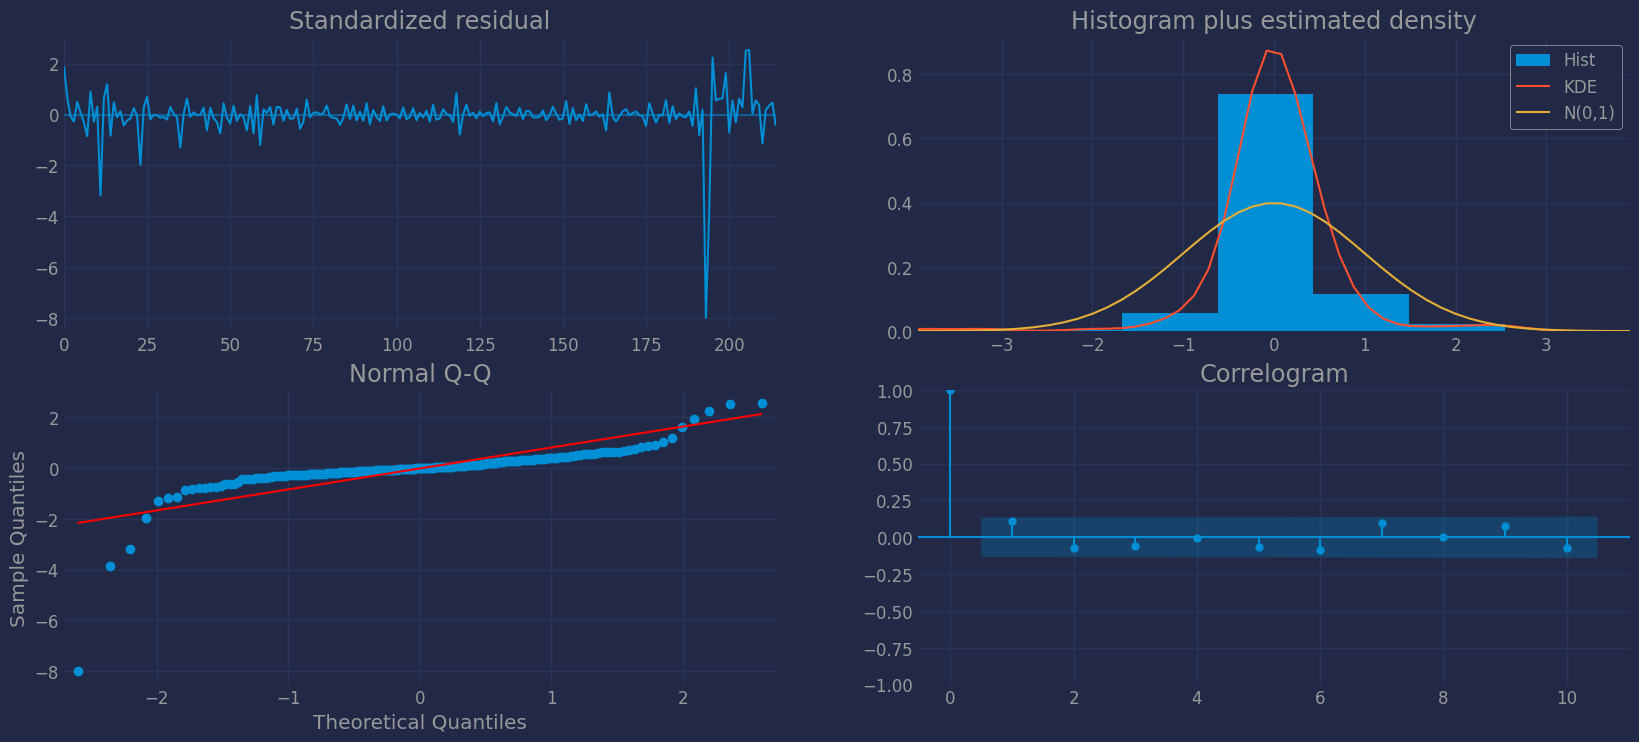

In [31]:
model_auto_sarima.plot_diagnostics(figsize=(18, 8))
plt.savefig("../graphics/SARIMA_con_covid/residuos", dpi=300, bbox_inches="tight")
plt.show

<a id='fit'></a>
## 5. MODEL FIT AND PREDICTION. FINAL ERRORS TEST

We obtain predictions with a 95% confidence interval.

In [32]:
forecast_auto_sarima = model_auto_sarima.predict(n_periods=21, return_conf_int=True)
forecast_values = forecast_auto_sarima[0]
confidence_int = forecast_auto_sarima[1]

c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Juanfran cd\Desktop\MATEMATICAS UA\TFG\TFG_github\TFG\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [33]:
y_auto_sarima = pd.DataFrame(forecast_auto_sarima[1], columns=(["low_yhat", "high_yhat"]))
y_auto_sarima["yhat"] = forecast_auto_sarima[0]
y_auto_sarima["date"] = pd.date_range(start="2022-01-01", periods=21, freq="MS")
y_auto_sarima = y_auto_sarima.set_index("date")
y_auto_sarima

,low_yhat,high_yhat,yhat
date,,,
2022-01-01,5.009370e+07,7.134008e+07,6.071689e+07
2022-02-01,4.096886e+07,7.542432e+07,5.819659e+07
2022-03-01,4.179684e+07,8.667266e+07,6.423475e+07
2022-04-01,2.990563e+07,8.344610e+07,5.667587e+07
2022-05-01,3.238662e+07,9.343261e+07,6.290962e+07
2022-06-01,3.434706e+07,1.020868e+08,6.821691e+07
2022-07-01,3.659762e+07,1.104304e+08,7.351401e+07
2022-08-01,3.072255e+07,1.101835e+08,7.045304e+07
2022-09-01,2.020834e+07,1.049247e+08,6.256651e+07


Plot of the predictios

In [34]:
# Predictions in-sample (over training data)
yhat_train = model_auto_sarima.predict_in_sample()
train_dates = df1["Date"].iloc[:len(yhat_train)]  

train_predictions = pd.DataFrame({
    "yhat": yhat_train,
    "date": train_dates
}).set_index("date")

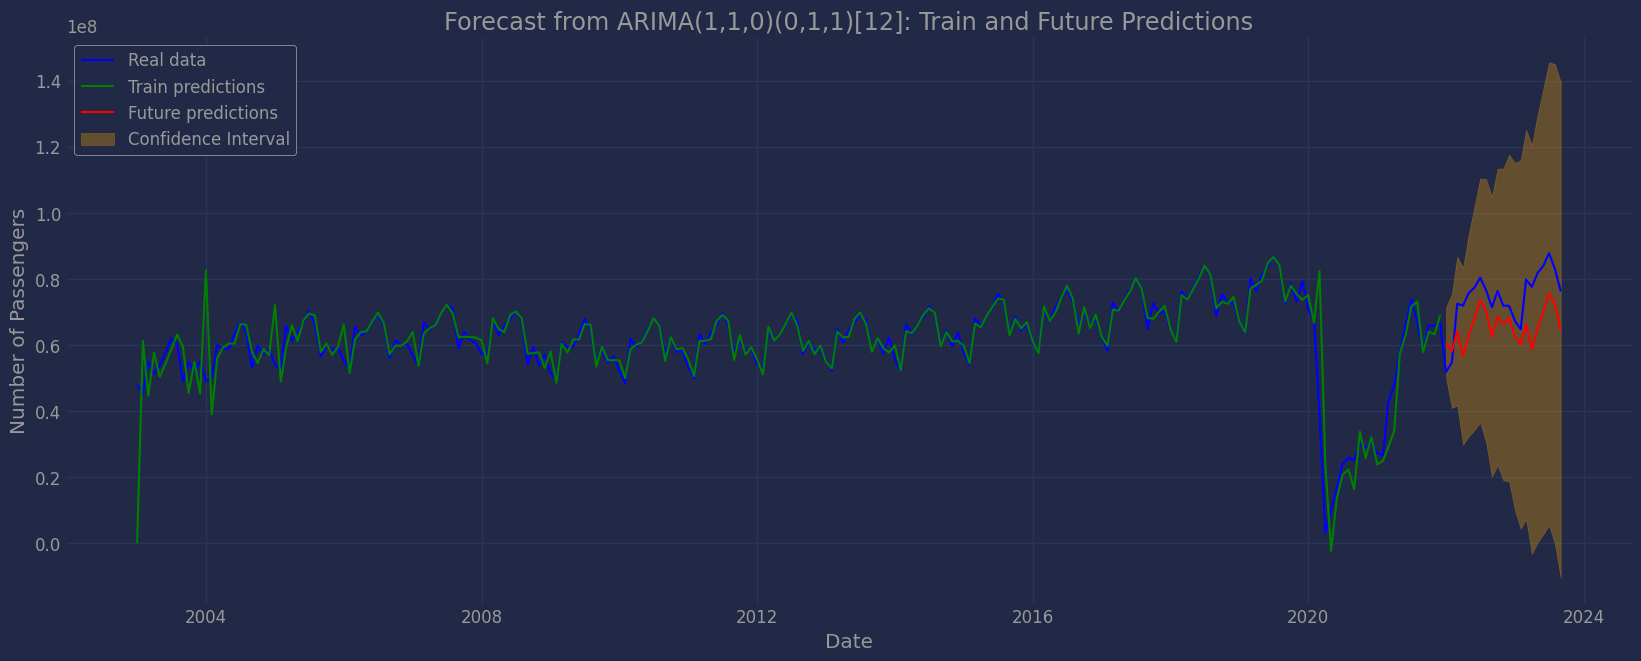

In [35]:
sns.lineplot(data=df1, x="Date", y="Pax", label="Real data", linewidth=1.5, color="blue")
plt.plot(train_predictions.index, train_predictions["yhat"], label="Train predictions", color="green")
plt.plot(y_auto_sarima.index, y_auto_sarima["yhat"], label="Future predictions", color="red")

plt.fill_between(
    y_auto_sarima.index,
    y_auto_sarima["low_yhat"],
    y_auto_sarima["high_yhat"],
    color="orange",
    alpha=0.3,
    label="Confidence Interval"
)

plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.title("Forecast from ARIMA(1,1,0)(0,1,1)[12]: Train and Future Predictions")
plt.legend()
plt.savefig("../graphics/SARIMA_con_covid/pred_con", dpi=300, bbox_inches="tight")
plt.show()

Finally, we evaluate the model by using the following metrics.

In [36]:
def EVAL_METRICS_FUNC(y_true, y_pred):
    def MAPE(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print("Metric evaluation result:-")
    print(f"MAE: {metrics.mean_absolute_error(y_true, y_pred)}")
    print(f"MAPE: {MAPE(y_true, y_pred)}")

For test set

In [37]:
EVAL_METRICS_FUNC(train["Pax"], train_predictions["yhat"])

Metric evaluation result:-
MAE: 2740255.232954434
MAPE: 8.652225270638416


For test set

In [38]:
EVAL_METRICS_FUNC(test["Pax"], y_auto_sarima["yhat"])

Metric evaluation result:-
MAE: 9715102.003379645
MAPE: 12.938783386389337
